In [1]:
# Importing the required packages
import os
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import stats
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
% matplotlib inline

In [2]:
# Setting the appropriate directories and importing the images
image_read_directory = 'test_images/'
image_write_directory = 'test_images_output/'
video_read_directory = 'test_videos/'
video_write_directory = 'test_videos_output/'
load_images = os.listdir(image_read_directory)
image_names = list(map(lambda img_name: image_read_directory+img_name,load_images))
read_images = list(map(lambda img: mpimg.imread(img),image_names))

In [3]:
# Creating a function to display images in 3 columns with the appropriate mapping
def display_images(images, columns= 3, fig_size=(12,12),img_labels = image_names):
    image_count = len(images)
    rows = image_count/columns
    cmap = None
    plt.figure(figsize=fig_size)
    for i in range(0, image_count):
        image_name = img_labels[i]
        plt.subplot(rows, columns, i+1)
        img = images[i]
        if len(img.shape) < 3:
            cmap = "gray"
        plt.title(image_name[len(image_read_directory):])    
        plt.imshow(img, cmap=cmap)
    plt.tight_layout()

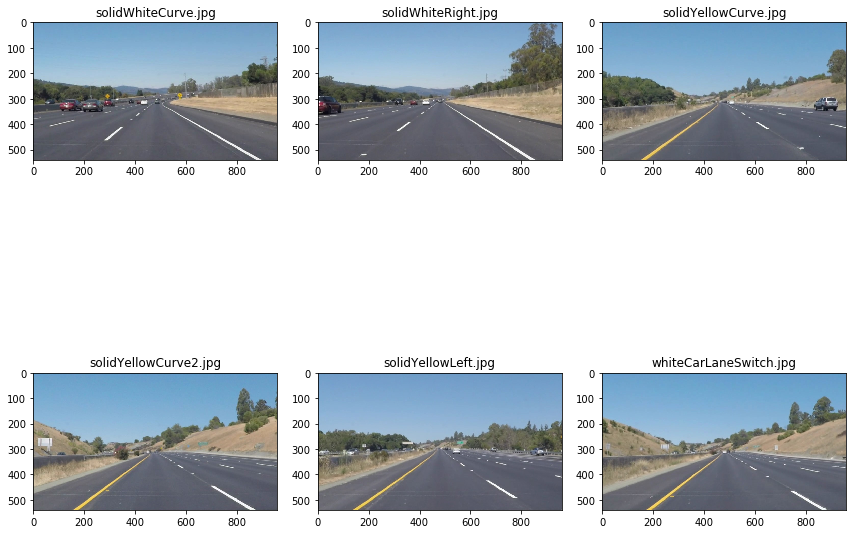

In [4]:
# Displaying the original images
display_images(read_images)

In [5]:
# Creating functions to convert images to Grayscale and YUV respectively
def image_in_grayscale(image):
    return cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
def image_in_YUV(image):
    return cv2.cvtColor(image,cv2.COLOR_RGB2YUV)

In [6]:
# Converting the images and storing them in a list
images_gray = list(map(lambda img: image_in_grayscale(img),read_images))
images_YUV = list(map(lambda img: image_in_YUV(img),read_images))

In [7]:
# Creating a threshold mask to isolate the yellow and white pixels in the image
def mask_apply(img,img_gray,img_yuv,yellow_threshold = 103, white_threshold = 207):
    img_copy = np.copy(img)
    white_thresh = (img_gray[:,:] < white_threshold)
    yellow_thresh = (img_yuv[:,:,1] > yellow_threshold)
    img_copy[white_thresh&yellow_thresh] = [0,0,0]
    return img_copy

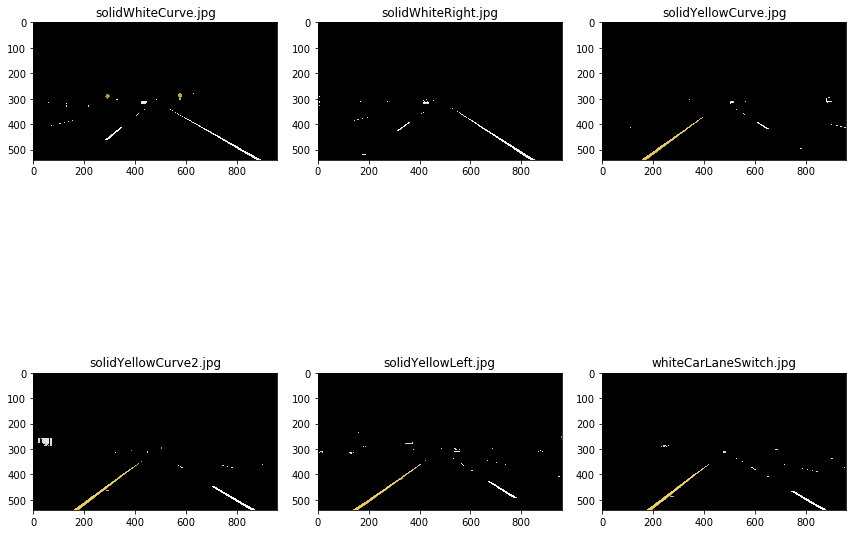

In [8]:
# Storing the images in a list with the appropriate thresholds applied
masked_images = list(map(lambda img,img_gray,img_yuv: mask_apply(img,img_gray,img_yuv),read_images,images_gray,images_YUV))
display_images(masked_images)

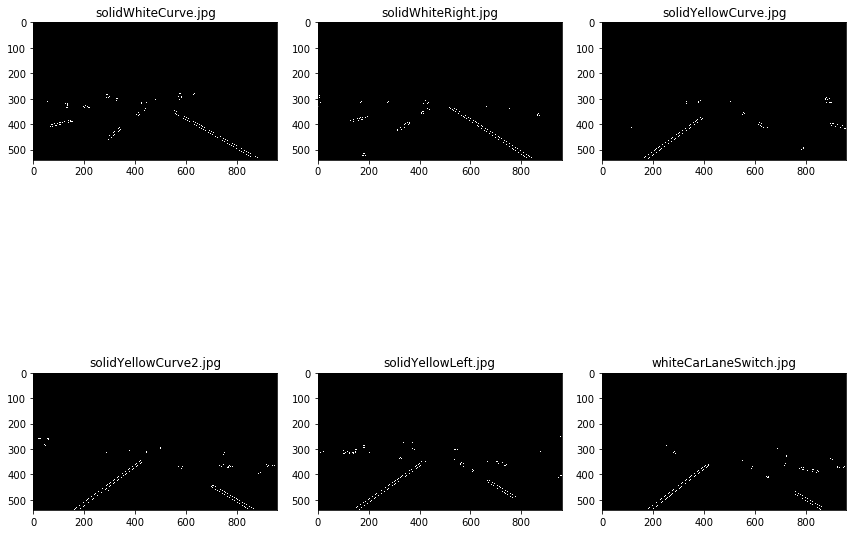

In [9]:
# Creating Functions to apply Gaussian blur and get the edges using Canny Edge Detection
def Gaussian_blur(image,kernel_size = 25):
    return cv2.GaussianBlur(image,(kernel_size,kernel_size),0)
def Canny_Edges(image,low = 5, high= 15):
    return cv2.Canny(image,low,high)
# Applying the above functions to the masked images and displaying them
blurred_images = list(map(lambda img: Gaussian_blur(img),masked_images))
edge_detected_images = list(map(lambda img:Canny_Edges(img),blurred_images))
display_images(edge_detected_images)

In [10]:
# A functions to map the vertices of the trapezoidal region of interest
def roi_vertices(img):
    img_size = img.shape
    X_lower_limit = int(0.47 * img_size[1])
    X_upper_limit = int(0.51 * img_size[1])
    Y_limit = int(0.6 * img_size[0])
#     vertices = np.array([[(0,img_size[0]),(450, 315), (490, 315),(img_size[1],img_size[0])]], dtype=np.int32)
    vertices = np.array([[(0,img_size[0]),(X_lower_limit, Y_limit), (X_upper_limit, Y_limit),(img_size[1],img_size[0])]], dtype=np.int32)
    return vertices

In [11]:
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    # Getting the vertices
    vertices = roi_vertices(img)
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

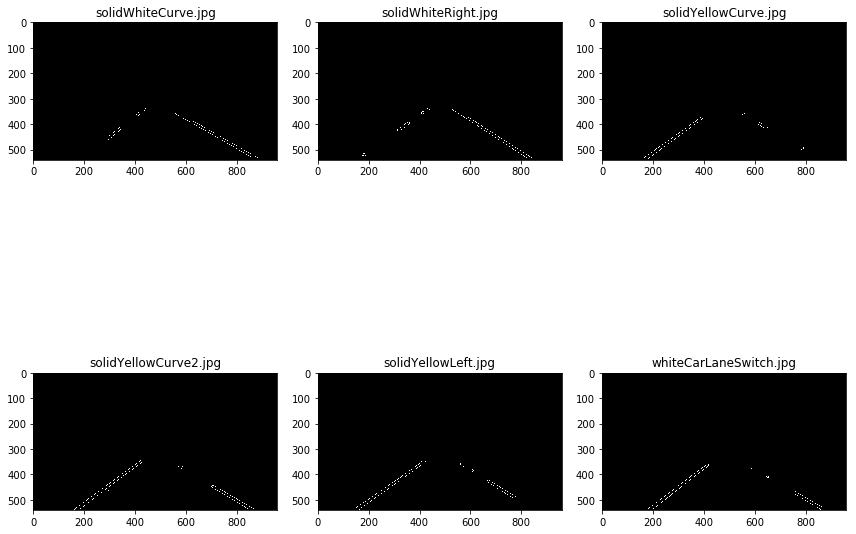

In [12]:
# Applying the Region of Interest mask and displaying them
masked_images = list(map(lambda img:region_of_interest(img),edge_detected_images))
display_images(masked_images)

In [13]:
# Function to extrapolate new points from known points
def create_points(lines,image):
    X_axis_points_left = []
    Y_axis_points_left = []
    X_axis_points_right = []
    Y_axis_points_right = []
    X_size = image.shape[1]
    Y_size = image.shape[0]
    Y_max = int(Y_size * 0.7)
    X_mid = int(X_size * 0.5)
#   Dividing the points into left lane and right lane points
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (x1 < X_mid & x2 < X_mid):
                X_axis_points_left.append(x1)
                X_axis_points_left.append(x2)
                Y_axis_points_left.append(y1)
                Y_axis_points_left.append(y2)
            else:
                X_axis_points_right.append(x1)
                X_axis_points_right.append(x2)
                Y_axis_points_right.append(y1)
                Y_axis_points_right.append(y2)
#   Creating new set of points in the Y-axis using the appropriate bounds
    Y_new_points = np.arange(Y_max,Y_size)
#   Applying Linear Regression to generate the slope of the left lane and right lane points
    slope_left, intercept_left, R_left, P_left, err_left = stats.linregress(X_axis_points_left,Y_axis_points_left)
    slope_right, intercept_right, R_right, P_right, err_right = stats.linregress(X_axis_points_right,Y_axis_points_right)
#   Generating X-axis points for the left lane and right lane respectively
    X_new_points_left = (Y_new_points-intercept_left)/slope_left
    X_new_points_right = (Y_new_points-intercept_right)/slope_right

    return X_new_points_left,Y_new_points,X_new_points_right

In [14]:
# Appending the points to create a line
def create_lines(x_points,y_points):
#     line_array = np.array([])
    line_array = []
    for k,j in enumerate(y_points):
        if k<(len(y_points)-1):
            line_array.append([[int(x_points[k]),y_points[k],int(x_points[k+1]),y_points[k+1]]])
    return line_array

In [15]:
def draw_lines(img, lines, original_img, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    img_size = img.shape
    X_mid = img.shape[1]*0.5
    for line in lines:
#   Dividing the coloration of the left lane and right lane to Red and Blue respectively
        for x1,y1,x2,y2 in line:
            if x1< X_mid and x2 < X_mid:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            else:
                color = [0,0,255]
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap,original_img):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    x_points_left, y_points,x_points_right = create_points(lines=lines,image=img)
    line_arr_left = create_lines(x_points_left,y_points)
    line_arr_right = create_lines(x_points_right,y_points)
#   Concatinating the left lane and right lane points to form a single lane array
    line_arr = line_arr_left+line_arr_right
    draw_lines(line_img, line_arr,original_img)
    return line_img


In [16]:
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 25     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 25 #minimum number of pixels making up a line
max_line_gap = 70    # maximum gap in pixels between connectable line segments
# line_image = np.copy(image)*0 # creating a blank to draw lines on

In [17]:
# Applying Hough Transform to the Region of Interest masked images
lined_images = list(map(lambda mask_img,org_img: hough_lines(mask_img,rho,theta,threshold,min_line_length,max_line_gap,org_img)\
                        ,masked_images,read_images))
# display_images(lined_images)

In [18]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

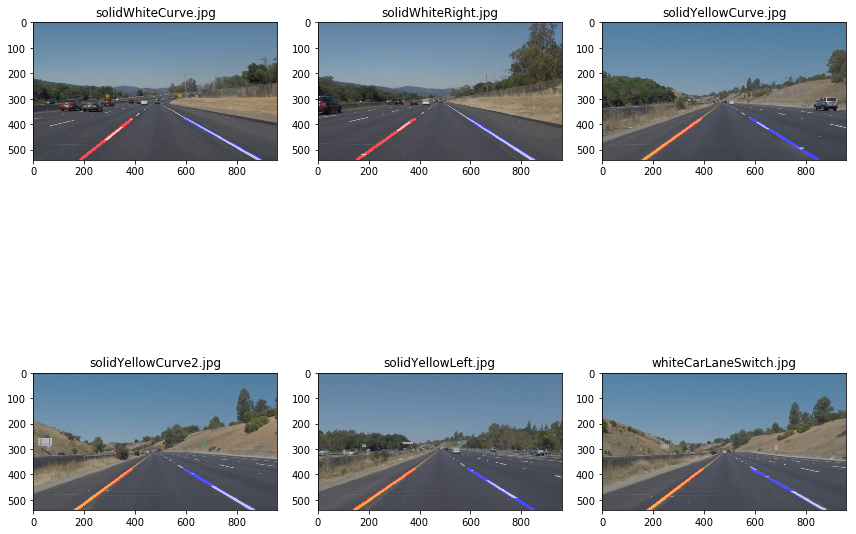

In [19]:
# Applying the transformations to the original images and displaying them
weighted_images = list(map(lambda hough_img,org_img: weighted_img(hough_img,org_img),lined_images,read_images))
display_images(weighted_images)

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    image_gray = image_in_grayscale(image)
    image_YUV = image_in_YUV(image)
    image_threshold = mask_apply(image,image_gray,image_YUV)
    image_blur = Gaussian_blur(image_gray)
    image_edge_det = Canny_Edges(image_blur)
    image_roi = region_of_interest(image_edge_det)
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 25     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 25 #minimum number of pixels making up a line
    max_line_gap = 70    # maximum gap in pixels between connectable line segments
    image_hough = hough_lines(image_roi,rho,theta,threshold,min_line_length,max_line_gap,image)
    result = weighted_img(image_hough,image)
    return result

In [22]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:09<00:00, 22.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 10.3 s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [24]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:32<00:00, 22.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 33.4 s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [26]:
# challenge_output = 'test_videos_output/challenge.mp4'
# ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
# ## To do so add .subclip(start_second,end_second) to the end of the line below
# ## Where start_second and end_second are integer values representing the start and end of the subclip
# ## You may also uncomment the following line for a subclip of the first 5 seconds
# ##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
# clip3 = VideoFileClip('test_videos/challenge.mp4')
# challenge_clip = clip3.fl_image(process_image)
# %time challenge_clip.write_videofile(challenge_output, audio=False)

In [27]:
# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(challenge_output))